In [91]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

import sys
import datetime

from pandas import Series, DataFrame
import pandas_datareader.data as web

In [92]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime.now()

#df = pd.read_csv('AAPL.csv')

data = web.DataReader("BTC-USD", 'yahoo', start, end)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100,398.821014


In [93]:
group = data.groupby('Date')
Daily_Price = group['Close'].mean()

Daily_Price.head()

Date
2014-09-16    457.334015
2014-09-17    424.440002
2014-09-18    394.795990
2014-09-19    408.903992
2014-09-20    398.821014
Name: Close, dtype: float64

In [94]:
Daily_Price.tail()

Date
2020-03-05    9078.762695
2020-03-06    9122.545898
2020-03-07    8909.954102
2020-03-08    8108.116211
2020-03-09    7814.960449
Name: Close, dtype: float64

In [118]:
from datetime import date

d0 = date(2016, 1, 1)
d1 = date(2017, 10, 15)
delta = d1 - d0
days_look = delta.days + 1
print(days_look)

d0 = date(2017, 8, 21)
d1 = date(2017, 10, 20)
delta = d1 - d0
days_from_train = delta.days + 1
print(days_from_train)

d0 = date(2017, 10, 15)
d1 = date(2017, 10, 20)
delta = d1 - d0
days_from_end = delta.days + 1
print(days_from_end)

654
61
6


In [119]:
df_train= Daily_Price[len(Daily_Price)-days_look-days_from_end:len(Daily_Price)-days_from_train]
df_test= Daily_Price[len(Daily_Price)-days_from_train:]

print(len(df_train), len(df_test))

599 61


In [120]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['Date'] = pd.to_datetime(working_data['Date'])
working_data = working_data.set_index('Date')

In [121]:
s = sm.tsa.seasonal_decompose(working_data.Close.values, freq=60)

In [122]:
trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

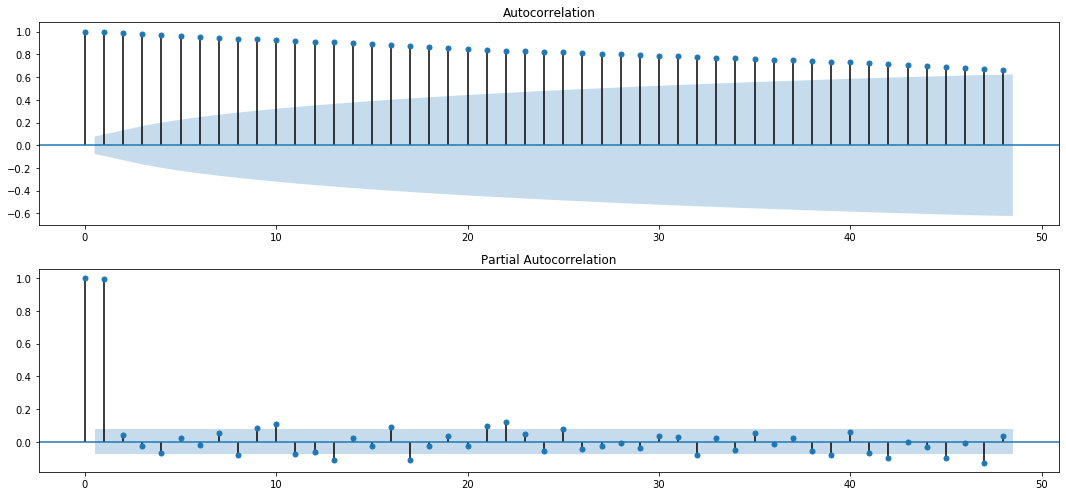

In [123]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(working_data.Close.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(working_data.Close.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [124]:
df_train = working_data[:-60]
df_test = working_data[-60:]

In [125]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [126]:
from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [127]:
# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False, 
                    validation_data=(X_test, Y_test), 
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Train on 599 samples, validate on 59 samples
Epoch 1/100
599/599 [==============================] - 2s 4ms/step - loss: 0.0507 - val_loss: 0.0183
Epoch 2/100
599/599 [==============================] - 0s 480us/step - loss: 0.0344 - val_loss: 0.0069
Epoch 3/100
599/599 [==============================] - 0s 490us/step - loss: 0.0183 - val_loss: 0.0101
Epoch 4/100
599/599 [==============================] - 0s 496us/step - loss: 0.0056 - val_loss: 0.0056
Epoch 5/100
599/599 [==============================] - 0s 479us/step - loss: 0.0015 - val_loss: 9.4731e-04
Epoch 6/100
599/599 [==============================] - 0s 486us/step - loss: 9.2021e-04 - val_loss: 7.1481e-04
Epoch 7/100
599/599 [==============================] - 0s 495us/step - loss: 9.2232e-04 - val_loss: 7.2080e-04
Epoch 8/100
599/599 [==============================] - 0s 514us/step - loss: 9.2450e-04 - val_loss: 7.2340e-04
Epoch 9/100
599/599 [==============================] - 0s 498us/step - loss: 9.2199e-04 - val_loss: 7.191

In [128]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training', 
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

In [129]:
# add one additional data point to align shapes of the predictions and true labels
X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0].reshape(1, 1)))
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [130]:
trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted price',
    hoverlabel= dict(namelength=-1),
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True price',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

In [131]:
RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 293.339


In [132]:
Test_Dates = Daily_Price[len(Daily_Price)-days_from_train:].index

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price', 
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=prediction2_inverse, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

In [133]:
# This function prepares random train/test split, 
# scales data with MinMaxScaler, create time series labels (Y)
def get_split(working_data, n_train, n_test, look_back = 1):
    # get a point from which we start to take train dataset and after it - test dataset
    start_point = randint(0, (len(working_data)-n_test-n_train))
    df_train = working_data[start_point:start_point+n_train]
    df_test = working_data[start_point+n_train:start_point+n_train+n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))
    
    # scale datasets
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # create datasets which are suitable for time series forecasting
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # reshape datasets so that they will be ok for the requirements of the models in Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))
    
    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# This function takes datasets from the previous function as input and train model using these datasets
def train_model(X_train, Y_train, X_test, Y_test):
    # initialize sequential model, add bidirectional LSTM layer and densely connected output neuron
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    
    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs = 100, batch_size = 16, shuffle = False, 
                    validation_data=(X_test, Y_test), verbose=0,
                    callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)])
    return model

# This function uses trained model and test dataset to calculate RMSE
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    # add one additional data point to align shapes of the predictions and true labels
    X_test = np.append(X_test, scaler.transform(working_data.iloc[start_point+n_train+len(X_test)][0].reshape(1, 1)))
    #X_test = np.append(X_test, scaler.transform(working_data.iloc[start_point+n_train+len(X_test)][0])
    X_test = np.reshape(X_test, (len(X_test), 1, 1))
    
    # get predictions and then make some transformations to be able to calculate RMSE properly in USD
    prediction = model.predict(X_test)
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
    prediction2_inverse = np.array(prediction_inverse[:,0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:,0])
    
    #calculate RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

In [134]:
def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

In [135]:
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 600,n_test = 60)
print('Test GRU model RMSE: %.3f' % RMSE)

Test GRU model RMSE: 24.019


In [136]:
# This function is used to repeat the workflow ten times and to calculate average RMSE
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

In [137]:
mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

Iteration: 1
Test RMSE: 16.295
Iteration: 2
Test RMSE: 70.024
Iteration: 3
Test RMSE: 3.474
Iteration: 4
Test RMSE: 30.718
Iteration: 5
Test RMSE: 23.830
Iteration: 6
Test RMSE: 66.324
Iteration: 7
Test RMSE: 51.347
Iteration: 8
Test RMSE: 60.968
Iteration: 9
Test RMSE: 22.563
Iteration: 10
Test RMSE: 57.533
Average RMSE:  40.3076539412952
RMSE list: [16.29530514082279, 70.02422674437531, 3.474407010862842, 30.717860637584582, 23.82993751347958, 66.32420444163402, 51.346774583981976, 60.96789431165771, 22.563272696356233, 57.53265633219696]


In [138]:
predictions_new = predictions - mean_rmse

RMSE_new = sqrt(mean_squared_error(Y_test2_inverse, predictions_new))
print('Test GRU model RMSE_new: %.3f' % RMSE_new)

Test GRU model RMSE_new: 17.961


In [139]:
trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price', 
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predictions_new, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

In [140]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8): 
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, predictions_new)

print('Test SMAPE (percentage): %.3f' % SMAPE)

Test SMAPE (percentage): 0.182
